TRAINING THE MODEL - FIRST 5 EPOCHS
Data size: 54,050 tokens
Vocabulary size: 34
Sequence length: 64
Batch size: 32

Using device: cuda

Train batches: 1519
Val batches: 169
Total backpropagations per epoch: 1519

Learning rate: 0.0003

TRAINING STARTED

Epoch 1/5
------------------------------------------------------------
  Batch 100/1519, Loss: 2.0256
  Batch 200/1519, Loss: 1.5473
  Batch 300/1519, Loss: 1.0730
  Batch 400/1519, Loss: 0.6954
  Batch 500/1519, Loss: 0.4730
  Batch 600/1519, Loss: 0.3891
  Batch 700/1519, Loss: 0.3061
  Batch 800/1519, Loss: 0.2260
  Batch 900/1519, Loss: 0.2119
  Batch 1000/1519, Loss: 0.1923
  Batch 1100/1519, Loss: 0.2047
  Batch 1200/1519, Loss: 0.1814
  Batch 1300/1519, Loss: 0.1528
  Batch 1400/1519, Loss: 0.1491
  Batch 1500/1519, Loss: 0.1438

Epoch 1 Summary:
  Train Loss: 0.6120
  Val Loss: 0.0873
  Time: 13.48s

  Generated: 'The cat would purr loudly. Tom loved his cat very much.
'

Epoch 2/5
----------------------------------------------

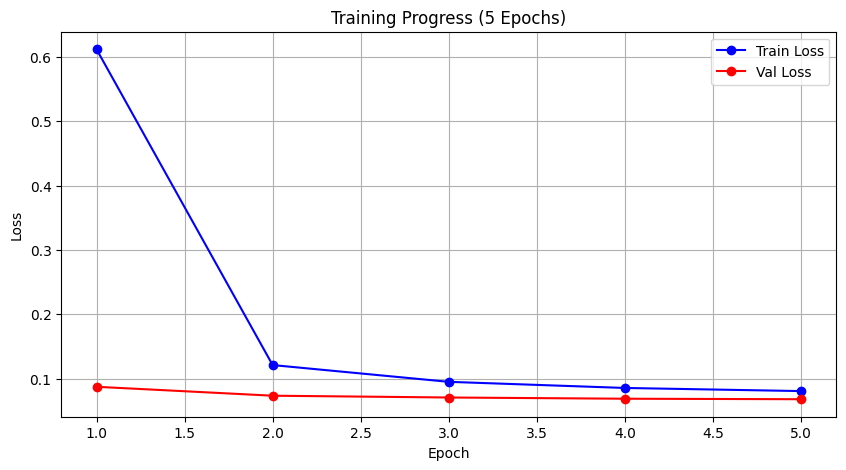


✓ Model checkpoint saved: model_checkpoint_epoch5.pt

NEXT: Inspect what the model learned!


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time

print("="*60)
print("TRAINING THE MODEL - FIRST 5 EPOCHS")
print("="*60)

# Load everything we need
data_config = torch.load('dataset_config.pt', weights_only=False)
model_checkpoint = torch.load('model_checkpoint_init.pt', weights_only=False)

data = data_config['data']
char_to_idx = data_config['char_to_idx']
idx_to_char = data_config['idx_to_char']
vocab_size = data_config['vocab_size']
seq_len = data_config['seq_len']
batch_size = data_config['batch_size']

print(f"Data size: {len(data):,} tokens")
print(f"Vocabulary size: {vocab_size}")
print(f"Sequence length: {seq_len}")
print(f"Batch size: {batch_size}")

# Rebuild model classes (same as before)
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout):
        super().__init__()
        assert embedding_dim % num_heads == 0
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.head_dim = embedding_dim // num_heads
        self.W_q = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.W_k = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.W_v = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.W_o = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.shape
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        attention_scores = Q @ K.transpose(-2, -1) / (self.head_dim ** 0.5)
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        attended = attention_weights @ V
        attended = attended.transpose(1, 2).contiguous()
        attended = attended.view(batch_size, seq_len, self.embedding_dim)
        output = self.W_o(attended)
        return output, attention_weights

class FeedForward(nn.Module):
    def __init__(self, embedding_dim, ff_dim, dropout):
        super().__init__()
        self.linear1 = nn.Linear(embedding_dim, ff_dim)
        self.linear2 = nn.Linear(ff_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = self.linear1(x)
        x = F.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.dropout(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embedding_dim, num_heads, ff_dim, dropout):
        super().__init__()
        self.attention = MultiHeadAttention(embedding_dim, num_heads, dropout)
        self.feed_forward = FeedForward(embedding_dim, ff_dim, dropout)
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.norm2 = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        attended, attn_weights = self.attention(self.norm1(x), mask)
        x = x + self.dropout(attended)
        ff_out = self.feed_forward(self.norm2(x))
        x = x + self.dropout(ff_out)
        return x, attn_weights

class GPT(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, num_layers, ff_dim, seq_len, dropout):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding = nn.Embedding(seq_len, embedding_dim)
        self.blocks = nn.ModuleList([
            TransformerBlock(embedding_dim, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])
        self.ln_f = nn.LayerNorm(embedding_dim)
        self.head = nn.Linear(embedding_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.seq_len = seq_len
    
    def forward(self, x):
        batch_size, seq_len = x.shape
        mask = torch.tril(torch.ones(seq_len, seq_len)).view(1, 1, seq_len, seq_len)
        mask = mask.to(x.device)
        token_emb = self.token_embedding(x)
        pos = torch.arange(seq_len, device=x.device)
        pos_emb = self.position_embedding(pos)
        x = self.dropout(token_emb + pos_emb)
        attention_weights = []
        for block in self.blocks:
            x, attn = block(x, mask)
            attention_weights.append(attn)
        x = self.ln_f(x)
        logits = self.head(x)
        return logits, attention_weights

# Create model and load initial weights
embedding_dim = model_checkpoint['embedding_dim']
num_heads = model_checkpoint['num_heads']
num_layers = model_checkpoint['num_layers']
ff_dim = model_checkpoint['ff_dim']
dropout = model_checkpoint['dropout']

model = GPT(vocab_size, embedding_dim, num_heads, num_layers, ff_dim, seq_len, dropout)
model.load_state_dict(model_checkpoint['model_state_dict'])

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
print(f"\nUsing device: {device}")

# Create dataset
class CharDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len
    
    def __len__(self):
        return len(self.data) - self.seq_len
    
    def __getitem__(self, idx):
        chunk = self.data[idx:idx + self.seq_len + 1]
        x = chunk[:-1]
        y = chunk[1:]
        return x, y

dataset = CharDataset(data, seq_len)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Total backpropagations per epoch: {len(train_loader)}")

# Setup optimizer
learning_rate = 3e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

print(f"\nLearning rate: {learning_rate}")

# Training function
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    
    for batch_idx, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        
        # Forward pass
        logits, _ = model(x)
        
        # Compute loss
        loss = F.cross_entropy(
            logits.view(-1, vocab_size),
            y.view(-1)
        )
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Print progress every 100 batches
        if (batch_idx + 1) % 100 == 0:
            print(f"  Batch {batch_idx+1}/{len(dataloader)}, Loss: {loss.item():.4f}")
    
    return total_loss / len(dataloader)

# Validation function
def validate(model, dataloader, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            logits, _ = model(x)
            loss = F.cross_entropy(logits.view(-1, vocab_size), y.view(-1))
            total_loss += loss.item()
    
    return total_loss / len(dataloader)

# Generation function
def generate(model, prompt, max_tokens=100, device='cpu'):
    model.eval()
    tokens = [char_to_idx[ch] for ch in prompt]
    
    with torch.no_grad():
        for _ in range(max_tokens):
            context = tokens[-seq_len:] if len(tokens) > seq_len else tokens
            x = torch.tensor([context], dtype=torch.long, device=device)
            
            if x.size(1) < seq_len:
                padding = torch.zeros(1, seq_len - x.size(1), dtype=torch.long, device=device)
                x = torch.cat([x, padding], dim=1)
            
            logits, _ = model(x)
            next_token_logits = logits[0, len(context)-1, :]
            probs = F.softmax(next_token_logits, dim=0)
            next_token = torch.multinomial(probs, 1).item()
            
            tokens.append(next_token)
            
            if idx_to_char[next_token] == '\n':
                break
    
    return ''.join([idx_to_char[t] for t in tokens])

print("\n" + "="*60)
print("TRAINING STARTED")
print("="*60)

# Track metrics
train_losses = []
val_losses = []

# Train for 5 epochs
num_epochs = 5
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()
    
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 60)
    
    # Train
    train_loss = train_epoch(model, train_loader, optimizer, device)
    train_losses.append(train_loss)
    
    # Validate
    val_loss = validate(model, val_loader, device)
    val_losses.append(val_loss)
    
    epoch_time = time.time() - epoch_start
    
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Time: {epoch_time:.2f}s")
    
    # Generate sample
    prompt = "The cat"
    generated = generate(model, prompt, max_tokens=50, device=device)
    print(f"\n  Generated: '{generated}'")

total_time = time.time() - start_time

print("\n" + "="*60)
print("TRAINING COMPLETE - 5 EPOCHS")
print("="*60)
print(f"Total time: {total_time/60:.2f} minutes")
print(f"Final train loss: {train_losses[-1]:.4f}")
print(f"Final val loss: {val_losses[-1]:.4f}")

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, 'b-o', label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, 'r-o', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress (5 Epochs)')
plt.legend()
plt.grid(True)
plt.savefig('training_5epochs.png', dpi=150, bbox_inches='tight')
plt.show()

# Save checkpoint
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': 5,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'embedding_dim': embedding_dim,
    'num_heads': num_heads,
    'num_layers': num_layers,
    'ff_dim': ff_dim,
    'vocab_size': vocab_size,
    'seq_len': seq_len,
    'dropout': dropout
}, 'model_checkpoint_epoch5.pt')

print("\n✓ Model checkpoint saved: model_checkpoint_epoch5.pt")
print("\n" + "="*60)
print("NEXT: Inspect what the model learned!")
print("="*60)

In [33]:
prompt = "there"
generated = generate(model, prompt, max_tokens=50, device=device)
generated

'there was a little girl named Lily. Lily loved to play '